In [2]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
df = pd.read_csv('test-data/2015_to_2022_dataset.csv')

In [4]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [5]:
df.isnull().sum()

Code                         0
Locale                       0
Date                         0
Temperature                  7
Precipitation            63134
Wind_Speed                  55
Wind_Direction              68
Humidity                    35
Vapor_Pressure               7
Dew_Point_Temperature       10
Spot_Atm_Pressure           21
Sea_Level_Pressure          17
Daylight_Time            32027
Insolation               31852
Snowfall_Amount          68051
Clouds_Amount             7111
Ground_Temperature          67
SO2                       1486
CO                        2672
NO2                       2074
PM10                      1436
PM2_5                     1330
O3                        1397
dtype: int64

In [6]:
# Define the columns to be imputed with the median
median_columns = [
    'Temperature', 'Wind_Speed', 'Wind_Direction', 'Humidity',
    'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure',
    'Sea_Level_Pressure', 'SO2', 'CO', 'NO2', 'PM10', 'PM2_5', 'O3',
    'Ground_Temperature'
]

# Define the columns to be imputed with zero
zeroing_columns = [
    'Precipitation', 'Daylight_Time', 'Insolation',
    'Snowfall_Amount', 'Clouds_Amount'
]

# Create imputer for median
imputer_median = SimpleImputer(strategy='median')

# Apply the imputer to the columns that require the median
df[median_columns] = imputer_median.fit_transform(df[median_columns])

# Fill the NaN values with zero for the columns that require zeroing
df[zeroing_columns] = df[zeroing_columns].fillna(0)

# Check if there are any remaining NaN values
print(df.isnull().sum())

Code                     0
Locale                   0
Date                     0
Temperature              0
Precipitation            0
Wind_Speed               0
Wind_Direction           0
Humidity                 0
Vapor_Pressure           0
Dew_Point_Temperature    0
Spot_Atm_Pressure        0
Sea_Level_Pressure       0
Daylight_Time            0
Insolation               0
Snowfall_Amount          0
Clouds_Amount            0
Ground_Temperature       0
SO2                      0
CO                       0
NO2                      0
PM10                     0
PM2_5                    0
O3                       0
dtype: int64


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d')
df['Date'] = df['Date'].astype(int)

In [8]:
df = df.drop(columns = ['Code', 'Locale'])

<AxesSubplot:>

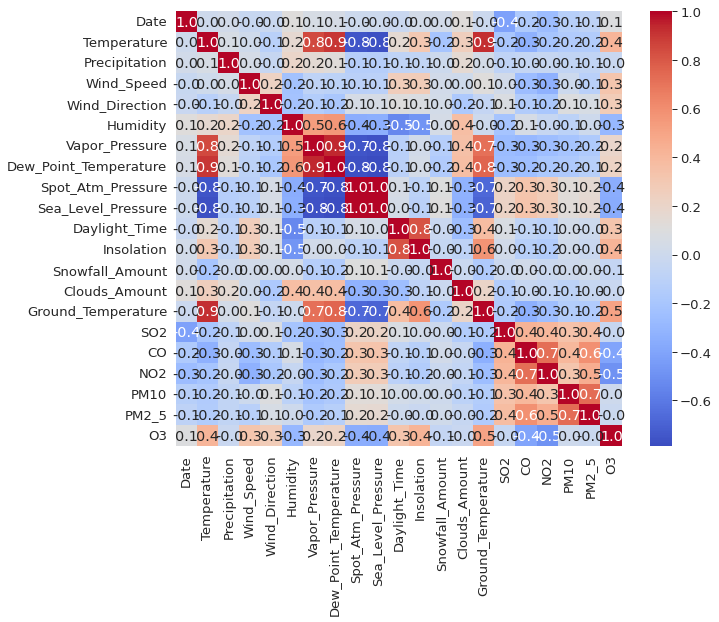

In [9]:
corr = df.corr()

sns.set_style('whitegrid')

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f')

In [10]:
# Specify the target variable
y = df['O3']

In [12]:
# Specify the feature variables
X = df.drop(['Date', 'O3'], axis=1)

In [13]:
# Feature Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 60, 90],
    'min_child_samples': [20, 30, 40]
}

In [16]:
# Initialize LGBMRegressor
lgbm = LGBMRegressor(random_state=42)

In [18]:
# Initialize GridSearchCV
grid_search = GridSearchCV(lgbm, param_grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

In [19]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 10, 20, 30],
                         'min_child_samples': [20, 30, 40],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [31, 60, 90]},
             scoring='neg_mean_squared_error')

In [20]:
# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 30, 'min_child_samples': 40, 'n_estimators': 200, 'num_leaves': 90}


In [21]:
# Initialize LGBMRegressor with the best parameters
model = grid_search.best_estimator_

In [22]:
# Fit the model
model.fit(X_train, y_train)

LGBMRegressor(max_depth=30, min_child_samples=40, n_estimators=200,
              num_leaves=90, random_state=42)

In [23]:
# Make predictions
predictions = model.predict(X_test)

In [24]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.007917


In [25]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

MAE: 0.005622


In [26]:
# Calculate R2 Score
r2 = r2_score(y_test, predictions)
print("R2 Score: %f" % (r2))

R2 Score: 0.829855


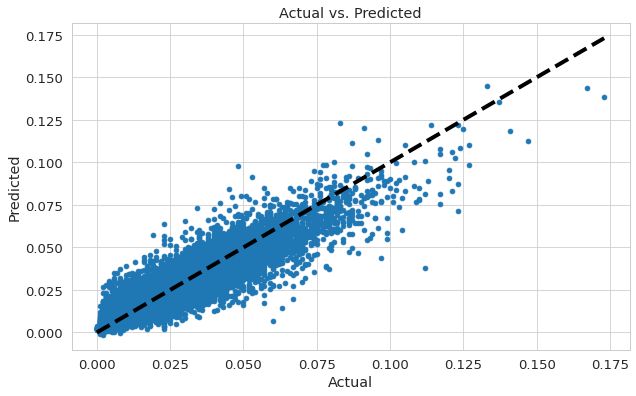

In [27]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

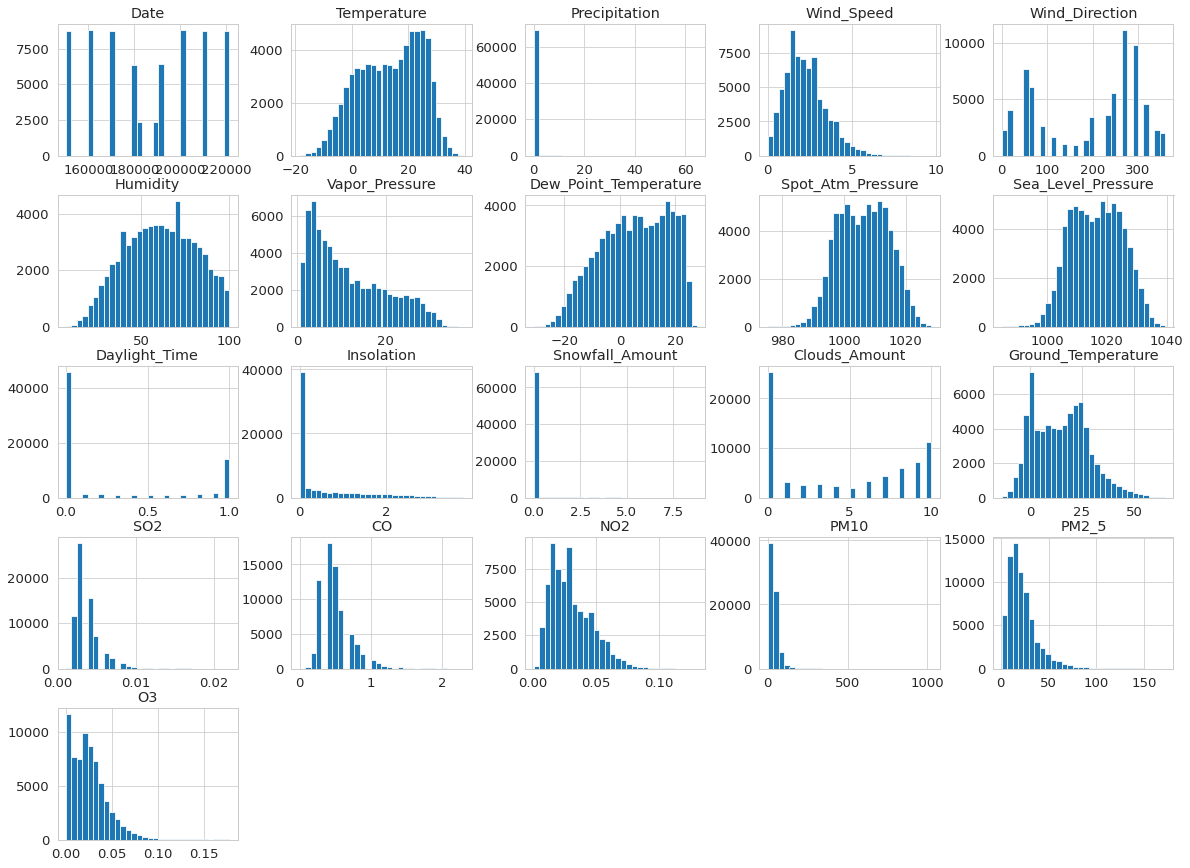

In [28]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(20,15))
plt.show()

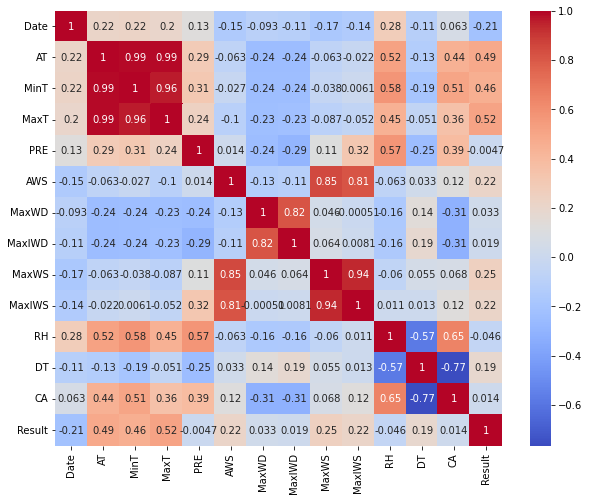

In [30]:
# Heatmap of Correlations
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

ValueError: num must be 1 <= num <= 15, not 16

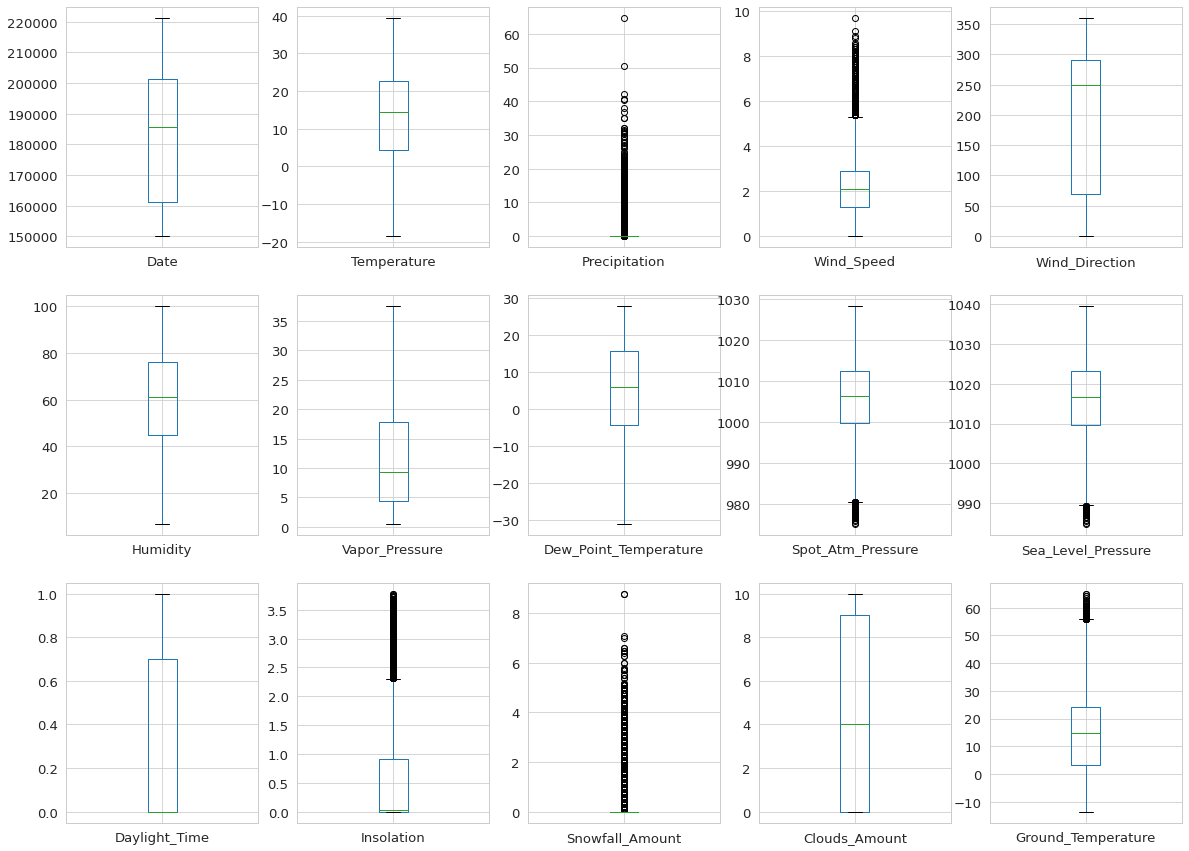

In [29]:
# Box plots for each variable
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    df.boxplot(column)
plt.show()